In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

# MNIST

A base de dados que utilizaremos é conhecida como MNIST ("Modified National Institute of Standards and Technology"), e deriva de uma base maior que foi construida pela NIST nos Estados Unidos (o equivalente da nossa ABNT). Esta base de dados é considerada o verdadeiro "Hello, world!" de métodos de classificação. Em http://yann.lecun.com/exdb/mnist/ temos uma descrição mais detalhada desta base de dados.

Nela, se encontram aproximadamente 70 mil imagens de 18 por 18 pixels. De todas essas, 60 mil são de treinamento e 10 são de teste.

Não é necessário baixar o dataset. O scikit-learn já tem ferramentas para baixar e disponibilizar alguns dos datasets mais comuns da comunidade de machine learning:

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True, parser='auto')

# A função fetch_openml() retorna targets como strings, precisamos converter para
# valores numéricos.
mnist.target = mnist.target.astype(np.int8)

mnist["data"], mnist["target"]

(       pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
 0           0       0       0       0       0       0       0       0       0   
 1           0       0       0       0       0       0       0       0       0   
 2           0       0       0       0       0       0       0       0       0   
 3           0       0       0       0       0       0       0       0       0   
 4           0       0       0       0       0       0       0       0       0   
 ...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
 69995       0       0       0       0       0       0       0       0       0   
 69996       0       0       0       0       0       0       0       0       0   
 69997       0       0       0       0       0       0       0       0       0   
 69998       0       0       0       0       0       0       0       0       0   
 69999       0       0       0       0       0       0       0       0       0   
 
        pixel1

No campo `data` temos as várias imagens de dígitos manuscritos. Cada item é uma lista de $28^2 = 784$ valores.

No campo `target` temos o rótulo de cada uma dessas imagens.

In [3]:
# X são as imagens (em arrays) e o y são os dígitos que estão sendo representados 
X, y = mnist['data'].to_numpy(), mnist['target'].to_numpy()
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Vamos ver um desses dígitos manuscritos para checar se a leitura de dados funcionou:

label: 5


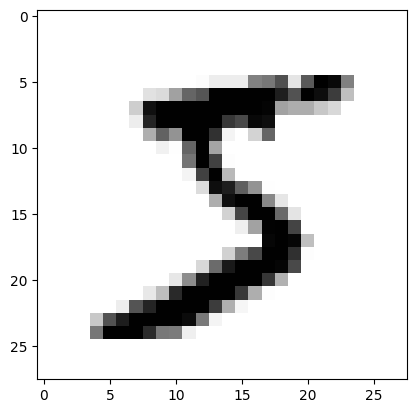

In [4]:
some_digit = X[0]
some_digit_label = y[0]

print(f'label: {some_digit_label}')

some_digit_image = some_digit.reshape(28, 28)  # Por que? Explique!

plt.figure()
plt.imshow(
    some_digit_image,
    cmap=matplotlib.cm.binary,
    interpolation='nearest',
)
plt.show()

# Separando treinamento e teste

Conforme visto na descrição do dataset MNIST, a separação entre conjunto de treinamento e teste já está feita. Neste caso, não devemos fazer a separação dos dados conforme visto na aula passada. 

Lembrando que as primeiras 60 mil imagens são de treinamento e as últimas 10 mil são de teste.

In [5]:
# vendo quanto de cada dígito você tem (pegando o "target" que é o dígito representado pela imagem do "data")
unique, counts = np.unique(mnist['target'][:60000], return_counts=True)
for u, c in zip(unique, counts):
    print(f'{u}: {c}')

0: 5923
1: 6742
2: 5958
3: 6131
4: 5842
5: 5421
6: 5918
7: 6265
8: 5851
9: 5949


In [6]:
# primeiros 60 mil
X_train = X[:60000]
y_train = y[:60000]

# tudo após 60 mil
X_test = X[60000:]
y_test = y[60000:]

# Classificação binária

Vamos começar com um problema mais simples: classificar os dígitos da base em 'cincos' e 'não-cincos'. Este é um problema de classificação binária. Por mera convenção, chamaremos de 'amostras positivas', ou simplemente 'positivos' os digitos $5$ e de 'negativos' os demais dígitos.

Vamos adaptar os conjuntos de treinamento e teste ao nosso cenário:

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Vamos agora treinar um classificador sobre todo o conjunto de treinamento, como fizemos na aula sobre regressão. Vamos usar um classificador chamado de *Stochastic Gradient Descent*, que é uma generalização de alguns tipos diferentes de classificadores mais tradicionais. O scikit-learn tem uma classe que implementa este classificador: `SGDClassifier`. Com os parâmetros default desta classe, o classificador SGD é equivalente a um classificador do tipo "máquina de vetores de suporte linear".



In [8]:
from sklearn.linear_model import SGDClassifier

# Existe aleatoriedade dentro do SGDClassifier, por isso o argumento 
# random_state=RANDOM_SEED.
sgd_clf = SGDClassifier(
    # iterações que o código realiza para montar o modelo
    max_iter=500,
    tol=1e-3,
    # colocando a random seed para garantir reprodutibilidade dos dados
    random_state=RANDOM_SEED,
)

# rodando o modelo
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(max_iter=500, random_state=42)

# Validação Cruzada

Podemos utilizar a estratégia de validação cruzada para melhor entendermos o desempenho do nosso modelo.

In [9]:
import time
from sklearn.model_selection import cross_val_score

t1 = time.process_time()
res = cross_val_score(
    # modelo declarado na célula acima
    sgd_clf,

    # imagens de treinamento (60 mil)
    X_train,

    # target modificado para incluir booleanos de se o número é 5 ou não
    y_train_5,

    # número de repartições da data que está chegando
    cv=3,

    # devolve a acurácia do modelo
    scoring="accuracy",

    # rodar mais rápido pois utiliza todos os núcleos da CPU ao mesmo tempo
    n_jobs=-1,
)
t2 = time.process_time()

print('Elapsed time: {}'.format(t2 - t1))
print(res)

Elapsed time: 0.546875
[0.95035 0.96035 0.9604 ]


Nossa medida de acurácia é muito boa. Uma acurácia de 96% é muito alta, em termos numéricos, mas será que isso é pouco para a situação que se encontra?

Por isso é necessário testarmos contra a hipótese nula. Nesse caso, teremos que observar qual é o elemento mais presente.

In [10]:
import numpy as np

unique, counts = np.unique(y_train_5, return_counts=True)

print(np.asarray((unique, counts)).T)

[[    0 54579]
 [    1  5421]]


Como visto acima, há muito mais números que não são 5 do que números que são cinco. A proporção está abaixo.

In [11]:
print(f'Porcentagem de números que não são cinco: {counts[0]/sum(counts)*100:.2f}%')
print(f'Porcentagem de números que  são cinco: {counts[1]/sum(counts)*100:.2f}%')

Porcentagem de números que não são cinco: 90.96%
Porcentagem de números que  são cinco: 9.04%


Para verificar a hipótese nula, iremos utilizar a classe `BaseEstimator` do `sklearn` para criar nosso classificador que sempre chuta que o número não é 5.

In [12]:
from sklearn.base import BaseEstimator


class Never5Classifier(BaseEstimator):

    def fit(self, X, y=None):
        # Nada a ser feito no treinamento.
        pass

    def predict(self, X):
        # Recebe len(X) amostras, chuta "False" como resposta para todas!
        return [False] * len(X)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(
    # classificador que sempre chuta que o número não é 5
    never_5_clf,

    # imagens de treinamento (60 mil)
    X_train,

    # target modificado para incluir booleanos de se o número é 5 ou não
    y_train_5,

    # número de repartições da data que está chegando
    cv=3,

    # devolve a acurácia do modelo
    scoring="accuracy",

    # rodar mais rápido pois utiliza todos os núcleos da CPU ao mesmo tempo
    n_jobs=-1,
)

array([0.91125, 0.90855, 0.90915])

Como é evidente na célula acima, temos uma acurácia de 90% se apenas chutarmos que o número não é cinco, independente dele ser ou não. Isso ocorre pois há 10 dígitos no total, e o nosso dataset tem aproximadamente 10% de cada dígito dentro dele.

# Matriz de Confusão. 

Essa é uma representação muito interessante para os modelos de classificação binária.

As colunas da matriz demonstram a predição do modelo, e as linhas o valor real.

A primeira linha indica dígitos "não-cinco", e a segunda linha indica os dígitos "cinco". Em problemas de classificação binária usamos a terminologia "negativos" (os "não-cinco") e "positivos" (os "cinco"), e dizemos também que nosso problema é "detectar" os dígitos "cinco".

- **TP**: Os valores **verdadeiramente positivos** e que foram **preditos como positivos** são os **true positives** (verdadeiros positivos).

- **FN**: Os valores **verdadeiramente positivos** e que foram **preditos como negativos** são os **false negatives** (falsos negativos, pois foram errôneamente classificados como negativos).

- **TN**: Os valores **verdadeiramente negativos** e que foram **preditos como negativos** são os **true negatives** (verdadeiros negativos).

- **FP**: os valores **verdadeiramente negativos** e que foram **preditos como positivos** são os **false positives** (falsos positivos, pois foram errôneamente classificados como positivos).


|             | Predito como Negativo | Predito como Positivo |
| ----------- | ----------- | ----------- |
| **Realmente Negativo** | True Negative | False Positive |
| **Realmente Positivo** | False Negative | True Positive |

Ela é uma ferramenta muito importante para ajudar na visualização do que realmente foi classificado corretamente, o que não foi e quais as proporções.

In [14]:
from sklearn.metrics import confusion_matrix

sgd_clf.fit(X_train, y_train_5)
y_train_pred = sgd_clf.predict(X_train)
mat = confusion_matrix(y_train_5, y_train_pred)
mat

array([[52316,  2263],
       [  601,  4820]], dtype=int64)

Ao rodar a célula (que pode demorar bastante), temos uma matriz com as seguintes características. 

$$
\left(\begin{array}{cc} 
52316 & 2263\\
601 & 4820
\end{array}\right)
$$ 

São:
- *True Negatives* (verdadeiramente negativos):
    - 52316 
- *False Positives* (falsamente preditos como positivos): 
    - 2263 
- *False Negatives* (erradamente preditos como negativos): 
    - 601 
- *True Positives* (verdadeiramente positivos): 
    - 4820 

Outra representação possível seria: 

|             | Predito como Negativo | Predito como Positivo |
| ----------- | ----------- | ----------- |
| **Realmente Negativo** | 52316 | 2263 |
| **Realmente Positivo** | 601 | 4820 |

# Predição Cruzada - 

Uma idéia melhor é aplicar o conceito de validação cruzada para realizar a predição de cada amostra. Funciona assim:

- Particionamos os dados em N partições.

- Para cada partição:

    - Treinamos o classificador sobre os dados das outras partições
    
    - Usamos o classificador para prever as classes das amostras desta partição

Por exemplo: suponha que temos 3 partições. As categorias preditas dos objetos da primeira partição são obtidas da seguinte forma:

- Treinamos o classificador usando os dados das partições 2 e 3

- Aplicamos o classificador para os objetos da partição 1. Guardamos estes resultados

Fazemos o mesmo para os objetos das partições 2 e 3. Desta forma, cada objeto foi predito de modo "honesto", ou seja, usando um classificador que não continha o próprio objeto como dado de treinamento!

O scikit-learn já tem uma função para fazer exatamente isso: `cross_val_predict`

In [15]:
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix

# Existe aleatoriedade dentro do SGDClassifier, por isso o argumento 
# random_state=RANDOM_SEED.
sgd_clf = SGDClassifier(
    # iterações que o código realiza para montar o modelo
    max_iter=500,
    tol=1e-3,
    # colocando a random seed para garantir reprodutibilidade dos dados
    random_state=RANDOM_SEED,
)

# rodando o modelo
sgd_clf.fit(X_train, y_train_5)

# criando a predição, com 3 repartições para a validação cruzada
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1)

# formando a matriz de confusão
mat = confusion_matrix(y_train_5, y_train_pred)
mat

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)